In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [30]:
data_a = pd.read_csv("/home/hexteran/Downloads/arbitrageFutureAData.csv", header = None)
data_b = pd.read_csv("/home/hexteran/Downloads/arbitrageFutureBData.csv", header = None)
data = pd.concat([data_a, data_b]).sort_values(0)
data.columns = ["ts", "symbol", "none", "bidsize", "bidprice", "askprice", "asksize"]

In [31]:
data_to_iterate = data.to_dict(orient = "list")
midprice_spread = {"ts":[], "value":[]}

prev_a = 0
prev_b = 0
for i in range(len(data)):
    if data_to_iterate["symbol"][i] == "FutureA":
        prev_a = (data_to_iterate["bidprice"][i] + data_to_iterate["askprice"][i])/2
        continue
    prev_b = (data_to_iterate["bidprice"][i] + data_to_iterate["askprice"][i])/2
    midprice_spread['ts'].append(data_to_iterate['ts'][i])
    midprice_spread['value'].append(prev_a - prev_b)   
midprice_spread = pd.DataFrame(midprice_spread)

Text(0.5, 1.0, 'Midprice spread')

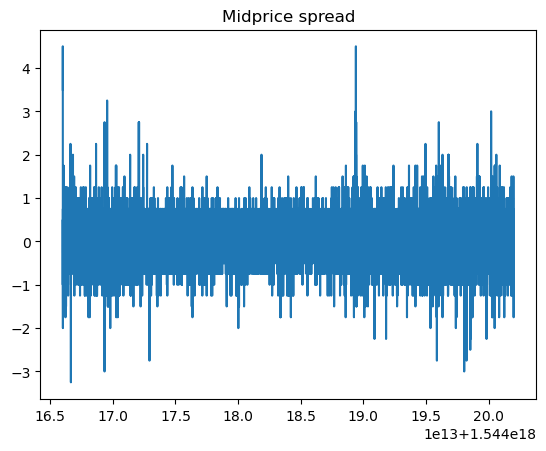

In [36]:
plt.plot(midprice_spread['ts'], midprice_spread['value'])
plt.title("Midprice spread")

## Case 1: X = 2, Y = 2, Z = -150; 0 latency on both legs

Text(0.5, 1.0, 'Simulated spread trades, X = 1; Y = 2; Z = -150')

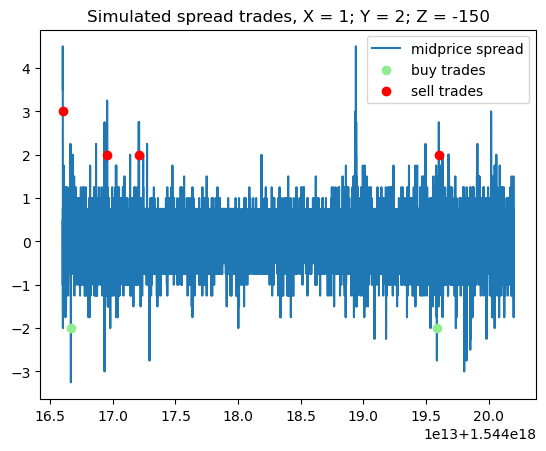

In [125]:
trades = pd.read_csv("../reports/trades_sample_X2_Y2_Z-150.csv", sep = ';')
trades['Side'] = trades['Side'].replace({'BUY': 1, 'SELL': -1})
trades_a = trades[trades['SecurityId'] == "FutureA"][['SentTimestamp','ExecPrice', 'Side']]
trades_b = trades[trades['SecurityId'] == "FutureB"][['SentTimestamp','ExecPrice', 'Side']]
merged = trades_a.merge(trades_b, on = 'SentTimestamp', suffixes = ['_A', '_B'])
merged["Spread"] = merged["ExecPrice_A"] - merged["ExecPrice_B"]
merged["Side"] = merged["Side_A"]

buys = merged[merged["Side"] == 1]
sells = merged[merged["Side"] == -1]
plt.plot(midprice_spread['ts'], midprice_spread['value'])
plt.scatter(buys["SentTimestamp"], buys["Spread"], color = "lightgreen", zorder = 2)
plt.scatter(sells["SentTimestamp"], sells["Spread"], color = "red", zorder = 2)
plt.legend(('midprice spread', 'buy trades', 'sell trades'))
plt.title("Simulated spread trades, X = 1; Y = 2; Z = -150")

**************************
**There are several occasions where we theoretically could have traded but missed the opportunity, but here midprice spread pretty much differs from actual tradable spread, so spikes in the middle can't be traded with X=2**
**************************

## Case 2: X = 1, Y = 2, Z = -150; 0 latency on both legs

Text(0.5, 1.0, 'Simulated spread trades, X = 1; Y = 2; Z = -150')

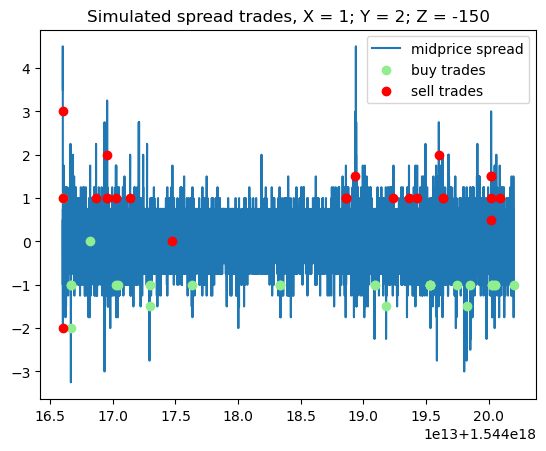

In [124]:
trades = pd.read_csv("../reports/trades_sample_X1_Y2_Z-150.csv", sep = ';')
trades['Side'] = trades['Side'].replace({'BUY': 1, 'SELL': -1})
trades_a = trades[trades['SecurityId'] == "FutureA"][['SentTimestamp','ExecPrice', 'Side']]
trades_b = trades[trades['SecurityId'] == "FutureB"][['SentTimestamp','ExecPrice', 'Side']]
merged = trades_a.merge(trades_b, on = 'SentTimestamp', suffixes = ['_A', '_B'])
merged["Spread"] = merged["ExecPrice_A"] - merged["ExecPrice_B"]
merged["Side"] = merged["Side_A"]

buys = merged[merged["Side"] == 1]
sells = merged[merged["Side"] == -1]
plt.plot(midprice_spread['ts'], midprice_spread['value'])
plt.scatter(buys["SentTimestamp"], buys["Spread"], color = "lightgreen", zorder = 2)
plt.scatter(sells["SentTimestamp"], sells["Spread"], color = "red", zorder = 2)
plt.legend(('midprice spread', 'buy trades', 'sell trades'))
plt.title("Simulated spread trades, X = 1; Y = 2; Z = -150")

***********
**Similar situation here, but some spikes from Case 1 are traded. Also there are two trades with spread = 0, this happened due to events sequencing (several updates with same timestamp)**
***********

## Case 3: X = 1, Y = 2, Z = -150; 0 latency on both legs

Text(0.5, 1.0, 'Simulated spread trades, X = 1; Y = 2; Z = -150')

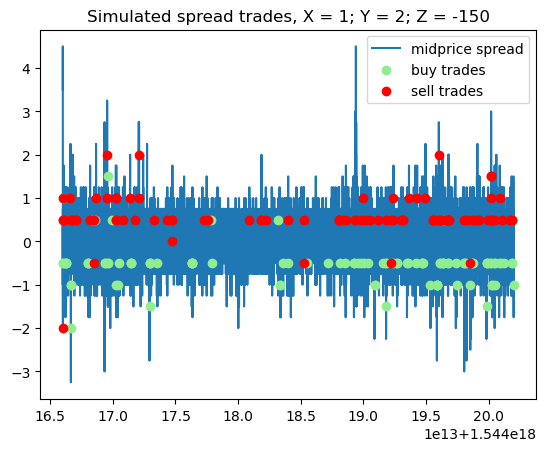

In [123]:
trades = pd.read_csv("../reports/trades_sample_X0.5_Y2_Z-150.csv", sep = ';')
trades['Side'] = trades['Side'].replace({'BUY': 1, 'SELL': -1})
trades_a = trades[trades['SecurityId'] == "FutureA"][['SentTimestamp','ExecPrice', 'Side']]
trades_b = trades[trades['SecurityId'] == "FutureB"][['SentTimestamp','ExecPrice', 'Side']]
merged = trades_a.merge(trades_b, on = 'SentTimestamp', suffixes = ['_A', '_B'])
merged["Spread"] = merged["ExecPrice_A"] - merged["ExecPrice_B"]
merged["Side"] = merged["Side_A"]

buys = merged[merged["Side"] == 1]
sells = merged[merged["Side"] == -1]
plt.plot(midprice_spread['ts'], midprice_spread['value'])
plt.scatter(buys["SentTimestamp"], buys["Spread"], color = "lightgreen", zorder = 2)
plt.scatter(sells["SentTimestamp"], sells["Spread"], color = "red", zorder = 2)
plt.legend(('midprice spread', 'buy trades', 'sell trades'))
plt.title("Simulated spread trades, X = 1; Y = 2; Z = -150")

***********
**There are several occasions when we traded a "wrong side", again, this happens due to the presence of two or more updates with the same timestamp, for example:**

24478 	1544168503613182310 	FutureA 	2 	1 	10883.5 	10884.0 	6

...

23117 	1544168503613220851 	FutureB 	14 	6 	10882 	10883 	1

23118 	1544168503613220851 	FutureB 	2 	6 	10882 	10884 	9


**Strategy received update 23117, so calculated tradable spread is 0.5 with respect to price 10883 for FutureB, but order is executed on the next update with price 10884, so we actually traded spread of -0.5**
***********

# What happens when we add execution latency? 

**Let's suppose Future A is traded in Chicago, Future B is traded in London; our trading server is located in London**

# Case 4: X = 2, Y = 1, Z = -150; FutureA: 40ms, FutureB: 1ms

Text(0.5, 1.0, 'Simulated spread trades, X = 1; Y = 2; Z = -150')

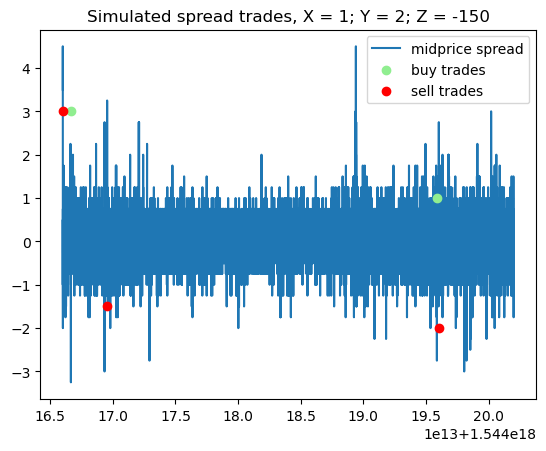

In [151]:
trades = pd.read_csv("../reports/trades_sample_X2_Y1_Z-150_latency.csv", sep = ';')
trades['Side'] = trades['Side'].replace({'BUY': 1, 'SELL': -1})
trades_a = trades[trades['SecurityId'] == "FutureA"][['SentTimestamp','ExecPrice', 'Side']]
trades_b = trades[trades['SecurityId'] == "FutureB"][['SentTimestamp','ExecPrice', 'Side']]
merged = trades_a.merge(trades_b, on = 'SentTimestamp', suffixes = ['_A', '_B'])
merged["Spread"] = merged["ExecPrice_A"] - merged["ExecPrice_B"]
merged["Side"] = merged["Side_A"]

buys = merged[merged["Side"] == 1]
sells = merged[merged["Side"] == -1]
plt.plot(midprice_spread['ts'], midprice_spread['value'])
plt.scatter(buys["SentTimestamp"], buys["Spread"], color = "lightgreen", zorder = 2)
plt.scatter(sells["SentTimestamp"], sells["Spread"], color = "red", zorder = 2)
plt.legend(('midprice spread', 'buy trades', 'sell trades'))
plt.title("Simulated spread trades, X = 1; Y = 2; Z = -150")

***
**Seems like such a latency is too much for this pair of instruments**
***

# Case 5: X = 0.5, Y = 1, Z = -150; FutureA: 40ms, FutureB: 1ms

Text(0.5, 1.0, 'Simulated spread trades, X = 1; Y = 2; Z = -150')

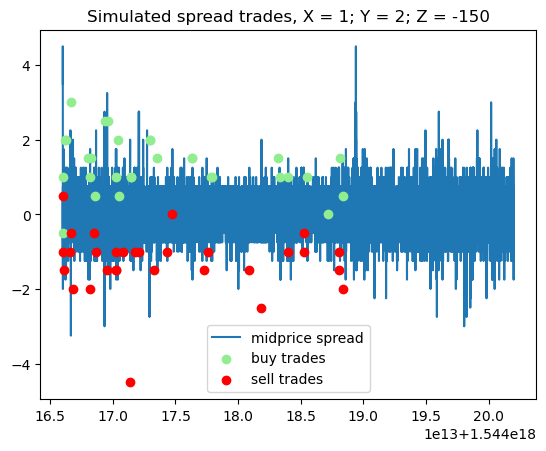

In [153]:
trades = pd.read_csv("../reports/trades_sample_X0.5_Y1_Z-75_latency.csv", sep = ';')
trades['Side'] = trades['Side'].replace({'BUY': 1, 'SELL': -1})
trades_a = trades[trades['SecurityId'] == "FutureA"][['SentTimestamp','ExecPrice', 'Side']]
trades_b = trades[trades['SecurityId'] == "FutureB"][['SentTimestamp','ExecPrice', 'Side']]
merged = trades_a.merge(trades_b, on = 'SentTimestamp', suffixes = ['_A', '_B'])
merged["Spread"] = merged["ExecPrice_A"] - merged["ExecPrice_B"]
merged["Side"] = merged["Side_A"]

buys = merged[merged["Side"] == 1]
sells = merged[merged["Side"] == -1]
plt.plot(midprice_spread['ts'], midprice_spread['value'])
plt.scatter(buys["SentTimestamp"], buys["Spread"], color = "lightgreen", zorder = 2)
plt.scatter(sells["SentTimestamp"], sells["Spread"], color = "red", zorder = 2)
plt.legend(('midprice spread', 'buy trades', 'sell trades'))
plt.title("Simulated spread trades, X = 1; Y = 2; Z = -150")

***
**With these parameters SL was triggered...**
***